
<img alt='UCL' src="images/ucl_logo.png" align='center'>




[<img src="images/noun_post_2109127.svg" width="50" align='right'>](051_Model_Fitting.ipynb)
[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](043_Weighted_interpolation.ipynb)



# 036 Models


## Introduction

In this session, we will consider the idea of a model in (Environmental) Science and discuss  a few examples.

## Prerequisites

You will need a good understanding of previous topics involving [`np/mgrid`](031_Numpy.ipynb#np.linspace,-np.arange,-np.mgrid) and [`np.newaxis`](032_More_numpy.ipynb#Reconciling-arrays:-np.newaxis). You should by know be familiar with other more basic material.


## Models 

We can think of a model as a 'process' box encapsulating our understanding, or a proposal for our understanding, of some process. Two examples we will cover later are:

* a descriptive model of vegetation phenology
* a model of snow-melt

Such models make an *output prediction* will be some variable, or set of variables. For our two example models, these will be:

* LAI as a function of time
* river flow resulting from snow-melt

The **outputs** depend on the mechanics of our model and:

* some set of **driving data** (in our two models this will be simply time, and time and temperature, respectively) 
* some model parameters

The model parameters control the operation of the model. These could be related to the type of vegetation for a phenology model, or terms such as the thickness of snowpack in the case of a snow-melt model. Most often, the parameters will describe *states* and *rates*, for example, the current amount of water in a snowpack (state) or the rate at which water is released from the snowpack into runoff (rate).

![model](images/parameters1.png)

We will generally have access to the driving data for our model, and we will have some set of measurements that correspond to the output, but we may not know the values of the parameters to use.

![model](images/parameters2.png)

How can we use this to provide an estimate of the model parameters? We could make some educated guesses, based on previous experience with the model in different situations ('expert opinion'), and we might also be able to provide reasonable bounds for the parameters, again either based on previous experience with the model or sometimes simply from physical limits (e.g. some parameters cannot be negative). 

What we really want is a more objective way of estimating the parameters. This involves parameter optimisation, which is a whole field of science. We cannot cover that in this course, but we can introduce some of the main ideas to use in our codes.

Before moving on to more 'realistic' models, let's build a simple example model `model` we can learn from. 

This has two parameters `p[0]` and `p[0]` and a driver that represents time:

In [7]:
# simple model 
def model(driver,param):
    '''2-parameter quadratic model with noise'''
    return param[0] + param[1] * driver * driver

We will generate a dataset `measure` at time samples `tmdriver` to represent our measurements, We generate them with the model with a set of parameters and some additive noise. We will also generate a set of weights for the observations, which we will use to indicate their reliability:

In [8]:
import numpy as np

# time driver every 4 days for measurement
tmdriver = np.arange(0,365,4,dtype=np.int)
# generate a pseudo-measurement
p0 = np.array([0.4,0.0002])
measure = model(tmdriver,p0) + 5*(np.random.random(tmdriver.shape)-0.5)
# just make up some weights for this exercise
measure_weight = (2 + np.random.random(tmdriver.shape))/4
# convert to std for plotting as previously
std = 1./np.sqrt(measure_weight) * 1.96

Now we forget that we know the parameters, make a guess that they are `[0.3,0.0001]`, and use the model to make a prediction `output`. Note that `output` exists every day, whereas the measurements are only every 4 days.

measurements: tmdriver shape (92,)
model output: tdriver shape  (365,)


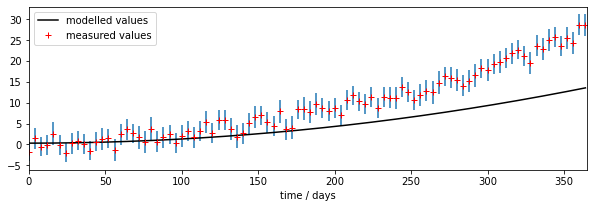

In [9]:
import matplotlib.pyplot as plt

# time driver every day
tdriver = np.arange(0,365,1,dtype=np.int)
# guess parameters
p = np.array([0.3,0.0001])
output  = model(tdriver,p)


# plot
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.set_xlim(0,365)
axs.plot(tdriver,output,'k',label='modelled values')
axs.errorbar(tmdriver,measure,yerr=std,ls='none')
axs.plot(tmdriver,measure,'r+',label='measured values')
# set legend now
axs.legend(loc='best')
axs.set_xlabel(f'time / days')

print(f'measurements: tmdriver shape {tmdriver.shape}')
print(f'model output: tdriver shape  {tdriver.shape}')

We can see right away that there is a mis-match between the model outputs and the measurements.

### discrepancy and optimisation

We have a set of *observations* that correspond to the model outputs at some time samples. 

A simple operation we can do is to compare these then. We might suppose that a set of parameters that provides a lower discrepancy between observations and modelled values (we will often call this error) is *objectively better* than one with a poorer match. In that sense, what we would need to do would be to search for a set of parameters that which has the minimum error. Our search for parameters will be guided by any bounds we set. Then all we need to do is write some computer code that considers different values of the parameters and reports on the best (the optimal) match.


![model](images/parameters3.png)

That is a reasonable approach, and one we will take in these notes. We should be aware that when we do Science however, we need to take into account uncertainty, and also that there might be other constraints we want to put on the problem.

Uncertainty manifests itself at all stages of modelling and optimisation: the model itself will be uncertain, because of its nature as an abstraction of some process; the drivers will often be uncertain in their ability to the conditions at the actual place and time we are doing the modelling; and the measurements will be uncertain. We have treated uncertainty in other sections of these notes by applying a weight to observations, and we can take the same approach here. When we calculate error, for instance as the root mean square error between model predictions (output) and measurement, we can weight this to give a weighted error.

Before we can calculate the (weighted) error, we need to treat the outputs so that they match the time samples of the measurements. We can either match the observations to the measurements, or the measurements to the observations. The best approach with depend on circumstances, but it is often easiest to match the measurements to the observations:

In [ ]:
# tmdriver time locations for measurements
# tdriver time locations for model outputs

# reconcile the model outputs 
# and measurements into same shape
# find the indices of the measurements
location_array = np.zeros_like(measure,dtype=np.int)
# populate location_array with indices of where measurement is
for i,t in enumerate(tmdriver):
    location = np.where(tdriver == t)
    if len(location[0]):
        location_array[i] = location[0][0]

In [ ]:
# now mapping output to sample_output is easy
sample_output = output[location_array]

In [ ]:
# now we can calculate the weighted discrepency 
error = (sample_output - measure)*measure_weight
error2 = error**2
rmse = np.sqrt(np.mean(error2))
print(f'RMSE: {rmse} for parameters {p}')

In [ ]:
# plot
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.set_xlim(0,365)
axs.plot(tmdriver,sample_output,'r+',label='sampled modelled values')
axs.plot(tmdriver,measure,'r+',label='measured values')
# plot the discrepencies in orange
axs.errorbar(tmdriver,measure,\
             yerr=[measure-measure,sample_output-measure],ls='none',\
             label='error')

# set legend now
axs.legend(loc='best')
axs.set_xlabel(f'time / days')

print(f'measurements: measure shape {measure.shape}')
print(f'model output: output shape  {output.shape}')
print(f'sample_output shape          {sample_output.shape}')

In [ ]:
# scatter plot
fig, axs = plt.subplots(1,1,figsize=(5,5))
# max value over all
maxvalue = np.array([measure,sample_output]).max()
axs.set_xlim(0,maxvalue)
axs.set_ylim(0,maxvalue)

axs.plot(measure,sample_output,'r+')
axs.errorbar(measure,sample_output,yerr=std,ls='none')

axs.set_ylabel(f'model output')
axs.set_xlabel(f'measurement')
# 1:1 line
axs.plot([0,maxvalue],[0,maxvalue],'k')

### Varying the parameters

We have seen how, once we have aligned the model outputs and observations, we can calculate a weighted measure if error, RMSE here. So, so some given set of measurements, a model, and a set of model parameters, we can calculate the error:

![model](images/parameters4.png)

Re-generate the set of measurements:

In [49]:
import numpy as np

# simple model 
def model(driver,param):
    '''2-parameter quadratic model with noise'''
    return param[0] + param[1] * driver * driver

# time driver every 4 days for measurement
tmdriver = np.arange(0,365,4,dtype=np.int)
# generate a pseudo-measurement
p0 = np.array([0.4,0.0002])
# np.random.random(tmdriver.shape)-0.5 -> zero mean noise
measure = model(tmdriver,p0) + 5*(np.random.random(tmdriver.shape)-0.5)
# just make up some weights for this exercise
measure_weight = (2 + np.random.random(tmdriver.shape))/4
# convert to std for plotting as previously
std = 1./np.sqrt(measure_weight) * 1.96

Recap on the core components so far, but setting the parameters to `numpy` arrays:

In [50]:

p0,p1 = np.array([0.1]),np.array([0.2])
tdriver = np.arange(0,365,1,dtype=np.int)
output  = model(tdriver,[p0,p1])


print(f'p0 shape:    {p0.shape}')
print(f'p1 shape:    {p1.shape}')
print(f'tdriver shape: {tdriver.shape}')
print(f'output shape:  {output.shape}')

p0 shape:    (1,)
p1 shape:    (1,)
tdriver shape: (365,)
output shape:  (365,)


Recall the material we covered in [032_More_numpy](032_More_numpy.ipynb#Reconciling-arrays:-np.newaxis). If we want to use a 2-D grid of shaoe `(Nxp,Nyp)` for `p0` and `p1`, we will have to make the driver shape `(1,1,365)` and the parameter shapes `(Nxp,Nyp,1)`:

In [51]:
# make a dummy 2-D parameter array
p0,p1 = np.array([[0.4,0.4],[0.3,0.3]]),np.array([[0.002,0.0001],[0.002,0.0001]])

p0_ext      = p0[:,:,np.newaxis]
p1_ext      = p1[:,:,np.newaxis]
tdriver_ext = tdriver[np.newaxis,np.newaxis,:]

print(f'p0_ext shape:      {p0_ext.shape}')
print(f'p1_ext shape:      {p1_ext.shape}')
print(f'tdriver_ext shape: {tdriver_ext.shape}')

# we can now call the model with extended arrays
output  = model(tdriver_ext,[p0_ext,p1_ext])
print(f'output shape:      {output.shape}')

p0_ext shape:      (2, 2, 1)
p1_ext shape:      (2, 2, 1)
tdriver_ext shape: (1, 1, 365)
output shape:      (2, 2, 365)


To make a comparison with a measurement array, we have to first select time periods in `output` corresponding to the measurements. We have done this above, creating a mask `location_array` of the same dimensions as the measurements:

In [52]:
# get measurement mask
location_array = np.zeros_like(measure,dtype=np.int)
# populate location_array with indices of where measurement is
for i,t in enumerate(tmdriver):
    location = np.where(tdriver == t)
    if len(location[0]):
        location_array[i] = location[0][0]
        
print(f'location_array shape: {location_array.shape}')
print(f'measure shape:        {measure.shape}')
print(f'measure_weight shape: {measure_weight.shape}')

location_array shape: (92,)
measure shape:        (92,)
measure_weight shape: (92,)


Next, select the outputs (along axis 2) from the modelling that correspond to the measurements:

In [53]:
# now mapping output to sample_output is easy
sample_output = output[:,:,location_array]
print(f'output shape:        {output.shape}')
print(f'sample_output shape: {sample_output.shape}')

output shape:        (2, 2, 365)
sample_output shape: (2, 2, 92)


We need to be able to compare `We need to be able to compare `sample_output` with `measure` and `measure_weight`, so lets do that to align with the parameter grid:

In [54]:
measure_ext        = measure[np.newaxis,np.newaxis,:]
measure_weight_ext = measure_weight[np.newaxis,np.newaxis,:]

print(f'measure_shape_ext:        {measure_ext.shape}')
print(f'measure_weight_ext shape: {measure_weight_ext.shape}')

measure_shape_ext:        (1, 1, 92)
measure_weight_ext shape: (1, 1, 92)


We can now perform element-wise operations involving `measure_ext`, `measure_weight_ext` and `sample_output`:

In [55]:
error_ext = (sample_output - measure_ext)*measure_weight_ext
error_ext = error_ext**2
print(f'error_ext shape: {error_ext.shape}')

error_ext shape: (2, 2, 92)


We now want the square root of the mean of this squared error term `error_ext` over time samples (axis 2):

In [56]:
rmse = np.sqrt(np.mean(error_ext,axis=2))
print(f'rmse shape {rmse.shape}')
print(f'parameters:\n{p0}\n{p1}')
print(f'-> rmse\n{rmse}')
min_rmse = rmse.min()
print(f'min rmse\n{min_rmse}')

# use np.where to find the minimum
ix,iy = np.where(rmse == min_rmse)
print(ix,iy)

rmse shape (2, 2)
parameters:
[[0.4 0.4]
 [0.3 0.3]]
[[0.002  0.0001]
 [0.002  0.0001]]
-> rmse
[[66.42002543  3.75544574]
 [66.37291744  3.80165273]]
min rmse
3.755445735240444
[0] [1]


In [57]:
print(f'parameters: {p0[ix,iy]} {p1[ix,iy]}')

parameters: [0.4] [0.0001]


Of the 4 combinations of parameters we examined, the parameters `[0.4,0.0001]` provide the best fit to the data. This makes sense, as we had generated the 'measurements' with:

    p0 = np.array([0.4,0.0002])

The RMSE for this set of parameters `3.80` is quite close to the RMSE for `[0.3,0.0001]`, so, from this set, we might consider both viable options.

### LUT inversion

This approach is called a Look-up table (LUT) inversion. It has the advantage of being quite fast if the total number of samples in the LUT can be kept down in number. This means that the limits to the problem need to be carefully considered: if your LUT inversion produces a supposed optimum parameter value that is on the bounds of the parameter space, then this can often be quite suspect: it may be that you just haven't sampled over a large-enough parameter space. The result is quantised to the LUT spacing if you use the simple approach here, but that will be fine for many applications. This is really only an appropriate method if you have a small number of parameters that you are solving for: i.e. a 1- or 2-Dimensional problem. If your model has more than 2 parameters, you may have to adopt a multi-pass strategy for parameter searching, or use a method other than LUT inversion.

#### Exercise 1

In a file `lut_RMSE.py` do the following:

        import numpy as np
        # define the min and max and step for the grid we want
        p0min,p0max,p0step = 0.0,10.0,0.05
        p1min,p1max,p1step = 0.0,0.001,0.000005

        gridp0,gridp1 = np.mgrid[p0min:p0max+p0step:p0step,\
                                 p1min:p1max+p1step:p1step]


* Write a function `gen_lut` to return a 2D parameter (Look up table -- LUT) grid using `np.mgrid` as above as `param = [gridp0,gridp1]`

        # simple model 
        def model(driver,param):
            '''2-parameter quadratic model with noise'''
            return param[0] + param[1] * driver * driver
          
* Write a function `model` to describe the model we will be using from the code above
 
        location_array = np.zeros_like(measure,dtype=np.int)
        # populate location_array with indices of where measurement is
        for i,t in enumerate(tmdriver):
            location = np.where(tdriver == t)
            if len(location[0]):
                location_array[i] = location[0][0]

 * A function `get_location_array` that takes as input:
 
        * tdriver:        array of (Nt,) floats of the day of year on which to do modelling
        * measure:        array of (Nm,) floats of measurements over sampled days of the year     
        * tmdriver:       array of (Nm,) integers: the days on which the measurements occur 
         
   and returns `location_array` array (Nm,) integers of the days of the measurements
            
        # code to use
        # time driver every 4 days for measurement    
        tmdriver = np.arange(0,365,4,dtype=np.int)
        # generate a pseudo-measurement
        p0 = np.array([0.4,0.0002])
        measure = model(tmdriver,p0) + 5*(np.random.random(tmdriver.shape)-0.5)
        # just make up some weights for this exercise
        measure_weight = (2 + np.random.random(tmdriver.shape))/4
        
        
* Write a function `gen_meas` to generate a pseudo-measurement based on the model and some noise. It should print the value of the parameters used in the model, and return `tmdriver, measure, measure_weight` corresponding to:

        * tdriver:        array of (Nt,) floats of the day of year on which to do modelling
        * measure:        array of (Nm,) floats of measurements over sampled days of the year
        * measure_weight: array of (Nm,) floats of the weights associated with the measurements

* Write a function `lut_RMSE` that takes as inputs:

        * `param`:          list of `[p0,p1]` with `p0` and `p1` being arrays of shape `(Np0,Np1)` representing a the LUT grid over parameter space
        * `tdriver`:         array of (Nt,) floats of the day of year on which to do modelling
        * `measure:`        array of (Nm,) floats of measurements over sampled days of the year
        * `measure_weight`: array of (Nm,) floats of the weights associated with the measurements
        * `tmdriver`:       array of (Nm,) integers: the days on which the measurements occur 
    
 That runs the model `model(tdriver,param)`, uses `get_location_array` to sample the model outputs coirresponding to the measurements, and calculates the weighted RMSE between the measurements and the modelled values for each parameter pair, and returns a grid of shape `(Np0,Np1)` values of RMSE associated with each parameter pair.
 
 * Write a function `runner()` that 
    * generates tdriver, the array of (365,) floats of the day of year on which to do modelling
    * gets a LUT `param` from `gen_lut`
    * gets a pseudo-measurement from `gen_meas`
    * gets a 2-D array of RMSE corresponding to the parameter grid
    * calculated and prints the value of the parameters corresponding to the minimum RMSE,
    * returns the RMSE array, the LUT, and the measurements
 
* Run `runner()` in a notebook
* Plot the RMSE values returned from this as an image
* Verify that you have identified the minimum RMSE
* Set different parameters in `gen_meas` to generate a different pseudo-measurement and repeat the process.

In [1]:
# ANSWER
!geog0111/lut_RMSE.py

original parameters: [0.4, 0.0002]
min rmse
2.4127966706577055
parameters: [0.25] [0.000205]


In [2]:
# ANSWER
import numpy as np
# Run runner() in a notebook
from geog0111.lut_RMSE import runner, model, gen_lut
RMSE,tdriver,(measure,measure_weight,tmdriver) = runner()
gridp0,gridp1 = gen_lut()

original parameters: [0.4, 0.0002]
min rmse
2.2314671758949163
parameters: [0.5] [0.0002]


In [3]:
# confirm
iy,ix = np.where(RMSE == RMSE.min())
gridp0[iy,ix],gridp1[iy,ix],RMSE[iy,ix]

(array([0.5]), array([0.0002]), array([2.23146718]))

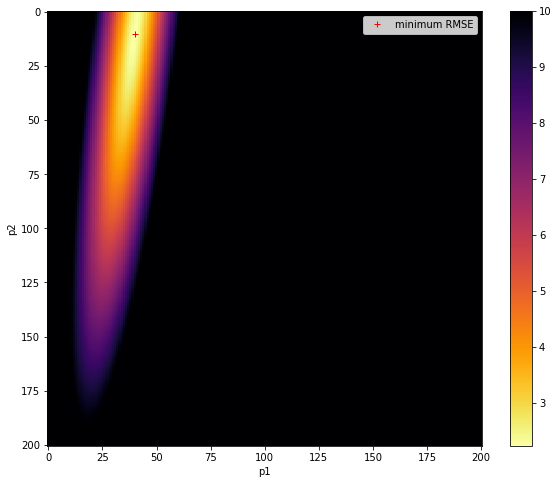

In [4]:
import matplotlib.pyplot as plt
# Plot the RMSE values returned from this as an image

# plot it
fig, axs = plt.subplots(1,1,figsize=(10,8))
im = axs.imshow(RMSE,interpolation="nearest",\
                vmax=10,cmap=plt.cm.inferno_r)
fig.colorbar(im, ax=axs)
axs.set_xlabel('p1')
axs.set_ylabel('p2')
plt.plot([ix],[iy],'r+',label="minimum RMSE")
axs.legend(loc='best')

original parameters: [0.0, 0.0005]
[0.25] [0.000495] [2.37015806]
min rmse
2.370158060903065


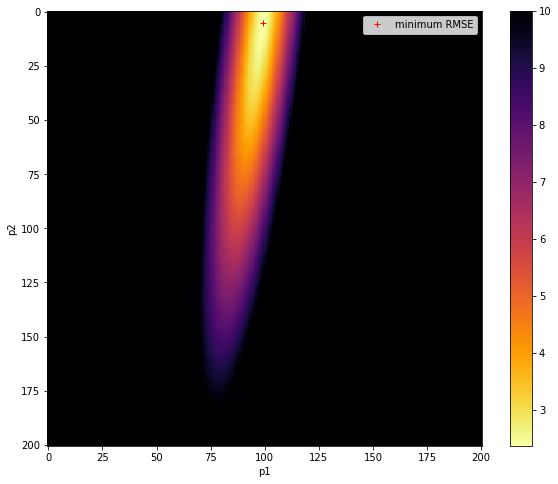

In [5]:
import numpy as np
from geog0111.lut_RMSE import gen_meas,model,lut_RMSE

# change the original parameters 

tdriver = np.arange(0,365,1,dtype=np.int)
param = gen_lut()
tmdriver,measure,measure_weight = gen_meas(p0=[0.0,0.0005])
RMSE = lut_RMSE(param,tdriver,measure,measure_weight,tmdriver)
min_rmse = RMSE.min()
iy,ix = np.where(RMSE == min_rmse)
print(gridp0[iy,ix],gridp1[iy,ix],RMSE[iy,ix])
print(f'min rmse\n{min_rmse}')
fig, axs = plt.subplots(1,1,figsize=(10,8))
im = axs.imshow(RMSE,interpolation="nearest",\
                vmax=10,cmap=plt.cm.inferno_r)
fig.colorbar(im, ax=axs)
axs.set_xlabel('p1')
axs.set_ylabel('p2')
plt.plot([ix],[iy],'r+',label="minimum RMSE")
axs.legend(loc='best')

In [4]:
              
def get_rmse(location_array,driver,p,measure,weight,mod=model):
    ''' get model-measurement error '''
    # time driver every day but sample only location_array
    output  = mod(driver,p)[location_array]
    error = (sample_output - measure)*weight
    error2 = error**2
    return np.sqrt(np.mean(error2))

p = np.array([0.3,0.0001])
tdriver = np.arange(0,365,1,dtype=np.int)
rmse = get_rmse(location_array,tdriver,p,measure,measure_weight)

print(f'RMSE: {rmse} for parameters {p}')

NameError: name 'model' is not defined

Recalling what we did in  [031_Numpy](031_Numpy.ipynb#np.linspace,-np.arange,-np.mgrid), lets generate a 2-D grid that we will use to sample the parameters:

In [ ]:
import matplotlib.pyplot as plt
# define the min and max and step for the grid we want
p0min,p0max,p0step = 0.0,0.5,0.05
p1min,p1max,p1step = 0.0,0.001,0.0001


gridp0,gridp1 = np.mgrid[p0min:p0max+p0step:p0step,\
                         p1min:p1max+p1step:p1step]

# plot it
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.plot(gridp0,gridp1,'+')
axs.set_xlabel('p1')
axs.set_ylabel('p2')

print(f'2d parameter grid: {gridp0.shape}')

Next, following the material we covered in [032_More_numpy](032_More_numpy.ipynb#Reconciling-arrays:-np.newaxis), we reconcile the parameter grid and the driver array.

In [ ]:
print(f'gridp0 shape: {gridp0.shape}')
print(f'gridp1 shape: {gridp1.shape}')

# extend the grid to match number of dimensions
gridp0ext = gridp0[:,:,np.newaxis]
gridp1ext = gridp1[:,:,np.newaxis]

location_arrayext = location_array[np.newaxis,np.newaxis,:]
measureext        = measure[np.newaxis,np.newaxis,:]

print(f'gridp0ext shape: {gridp0ext.shape}')
print(f'gridp1ext shape: {gridp1ext.shape}')

print(f'location_arrayext shape: {location_arrayext.shape}')
print(f'measureext shape:        {measureext.shape}')

c1 = gridp0ext + measureext 
print(f'c1 shape: {c1.shape}')

Now, calculate the RMSE for each point on the grid:

In [ ]:
model(np.expand_dims(tdriver, axis=(0,1)),np.expand_dims(np.array([p1,p2],axis=2)))

In [ ]:
np.expand_dims(tdriver, axis=(0,1))

In [ ]:
np.expand_dims(p2,axis=2).shape

In [ ]:
(np.expand_dims(tdriver, axis=(0,1)) + np.expand_dims(p2,axis=2)).shape

# 036 Model Fitting 

We use many models in Science. Typical models in Environmental science will have 


### Test

You should run a [NASA account test](004_Accounts.ipynb) if you have not already done so.

Fit to LAI curves ...

In the previous session, we looked at fitting linear models to observations. While this is a very common task, complex processes might require models which are non-linear.

One non-linear model is modelling LAI as a function of time (or temperature). In the Nothern Hemisphere, and for temperate latitudes, there is a clear seasonal cycle in vegetation, particularly visible in leaf area index (LAI). LAI dynamics can possibly be depicted by a "double logistic" curve. Mathematically, the double logistic looks like this


![A double logistic](https://camo.githubusercontent.com/7a664a29ec5bc190d71d8ba5ec391bcf98848df7/687474703a2f2f777777322e67656f672e75636c2e61632e756b2f7e706c657769732f67656f67673132342f5f696d616765732f7a68616e67312e706e67)

Mathematically, the function predicts the e.g. LAI (or some vegetation index) as

$$
y = p_0 - p_1\cdot\left[\frac{1}{1+\exp\left(p_2\cdot(t-p_3)\right)} + \frac{1}{1+\exp\left(-p_4\cdot(t-p_5)\right)} - 1\right].
$$

If we inspect this form, we can probably guess that $p_0$ and $p_1$ scale the vertical span of the function, whereas $p_3$ and $p_5$ are some sort of temporal shift, and the remaining parameters $p_2$ and $p_4$ control the slope of the two flanks. Something that will give rise to a self-respecting LAI curve might be

* $p_0= 0.1$
* $p_1= 2.5$
* $p_2=0.19$
* $p_3= 120$
* $p_4= 0.13$
* $p_5= 220$

<div class="alert alert-danger">
<p>Write a function that produces the double logistic when passed an array of time steps (e.g. 1 to 365), and an array with six parameters.</p>
<p>Do some plots and try to get some intuition on the model parameters!</p>
</div>



In [ ]:
# All imports go here. Run me first!
import datetime
from pathlib import Path  # Checks for files and so on
import numpy as np  # Numpy for arrays and so on
import pandas as pd
import sys
import matplotlib.pyplot as plt  # Matplotlib for plotting
# Ensure the plots are shown in the notebook
%matplotlib inline

import gdal
import osr
import numpy as np
%matplotlib inline

## A synthetic experiment

A first step is to do a synthetic experiment. This has the marked advantage of being a situation where we're in control of everything. 

In [ ]:

t = np.arange(1, 366)
p = np.array([0.1, 2.5, 0.19, 120, 0.13, 220])
y = dbl_sigmoid_function(p, t)
yn = y + np.random.randn(len(t))*0.6

selector = np.random.rand(365)

passer = np.where(selector > 0.9, True, False)

tn = t[passer]
yn = yn[passer]

fig = plt.figure(figsize=(15, 4))
_ = plt.plot(t, y, '-', label="Ground truth")
_ = plt.plot(tn, yn, 'o', label="Simulated observations")
plt.legend(loc="best")
plt.xlabel("DoY")
plt.ylabel("LAI")



We know that the "true parameters" are given by `p = np.array([0.1, 2.5, 0.19, 120, 0.13, 220])`, but we see that the data is quite noisy and has significant gaps. As per last session, we could try to modify the parameters "by hand", and see how far we get, but given that it's 6, with different ranges, it looks a bit daunting. Also, we'd need to assess how good the solution is for a particular set of parameters, in other words, select a metric to quantify the goodness of fit.

It is useful to consider a model of the incomplete, noisy observations of LAI ($y_n$) and the true value of LAI, $y$. For overlapping time steps, the noisy data are just the "true" data plus some random Gaussian value with zero mean and a given variance $\sigma_{obs}^2$ (in the experiment above, $\sigma_{obs}=0.6$):

$$
y_n^{i} = y^{i} + \mathcal{N}(0, \sigma_{obs}^2).
$$

Rearranging things, we have that $y_n - y$ should be a zero mean Gaussian distribution with known variance. We have assumed that our model is $f(\vec{p})=y$, so we can write the *likelihood function*, $l(\vec{p})$

$$
l(\vec{p}) = \left[\frac{1}{\sqrt{2\pi\sigma_{obs}^2}}\right]^{N}\displaystyle{\prod_{i=1}^{N} \exp\left[-\frac{(y_n^{i}-f(\vec{p})^{i})^2}{2\sigma_{obs}^2}   \right]}.
$$

It is convenient to take a logarithm of $l(\vec{p})$, so that we have the **log-likelihood**:

$$
L(\vec{p}) = -\displaystyle{\sum_{i=1}^{N} \left[\frac{(y_n^{i}-f(\vec{p})^{i})^2}{2\sigma_{obs}^2}   \right]} + \textrm{Const.}
$$

<div class="alert alert-success">
Think about the likelihood and log-likelihood... Think (and possibly plot) how a negative exponential curve looks like, and what conditions are for some interesting points.
</div>

So for a sum of squares, the most likely result would be if all the mismatches were zero, which means that the log-likelihood is 0, and the likelihood, $exp(0)=1$! 

However, the mismatch might not be 0, due to the added noise. So what we're effectively looking for is a **maximum** in the log-likelihood, or a **minimum** of its negative as a function of $\vec{p}$:

$$
\frac{\partial (-L(\vec{p}))}{\partial \vec{p}} \triangleq \min
$$

So, we can try our brute force guessing approach by **minimising the cost function given by $L(\vec{p})$**

<div class="alert alert-danger">
Write the cost function! Test it possibly shifting one parameter over some range of values
</div>

The easiest way to obtain the solution is to use numerical optimisation techniques to minimise the cost function. In scipy, there's [a good selection of function optimisers](https://docs.scipy.org/doc/scipy/reference/optimize.html). We'll be looking at **local** optimisers: these will look for a minimum in the vicinity of a user-given starting point, usually by looking at the gradient of the cost function. The main function to consider here is [`minimise`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize). Basically, `minimize` takes a cost function, a starting point, and maybe extra arguments that are passed to the cost function, and uses one of several algorithms to minimise the cost function. We import it with

```python
    from scipy.optimize import minimize
```

From the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize),
```python
    minimize(fun, x0, args=(), method=None,
             jac=None, hess=None, hessp=None,
             bounds=None, constraints=(), tol=None,
             callback=None, options=None)
```

Basically, `fun` is the name of the cost function. The first parameter you pass to the cost function has to be an array with the parameters that will be used to calculate the cost. `x0` is the starting point. `args` allows you to add extra parameters that are required for the cost function (in our example, these would be `t, y_obs, passer, sigma_obs`).

The `minimize` function returns an object with the 

1. Value of the function at the minimum,
2. The value of the input parameters that attain the minimum,
3. A message telling you whether the optimisation succeeded
4. The number of iterations (`nit`) and total function evaluations (`nfev`)
5. Some diagnostics 





In [ ]:
from scipy.optimize import minimize

In [ ]:
from scipy.optimize import minimize

p0 = np.array([0, 5, 0.01, 90, 0.01, 200])

retval = minimize(cost_function, p0, args=(t, yn, passer, 0.6))

print(retval)

print ("********************************************")
if retval.success:
    print("Optimisation successful!")
    print(f"Value of the function at the minimum: {retval.fun:g}")
    print(f"Value of the solution: {str(retval.x):s}")

<div class="alert alert-danger">
Do some synthetic experiments. For example:
<ol>
    <li> Change the true parameters and see how the solution tracks the change.</li>
    <li> Increase the added variance</li>
    <li> Reduce or increase the number of observations</li>
</ol>

Use these experiments to challenge your understanding of the problem: Try to think what the expected result of these changes is, and write a set of functions that simplify the exploration.
</div>






[<img src="images/noun_post_2109127.svg" width="50" align='right'>](051_Model_Fitting.ipynb)
[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](043_Weighted_interpolation.ipynb)

